<a href="https://colab.research.google.com/github/sampintu8658/10/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**For Extract text**


In [ ]:
!pip install -U -q google-generativeai
!apt-get install -y poppler-utils
!pip install -q -U google-generativeai pdf2image

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import json
import pathlib
import textwrap

import google.generativeai as genai


from IPython.display import display
from IPython.display import Markdown

from google.api_core import retry

def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

In [ ]:
try:
    # Used to securely store your API key
    from google.colab import userdata

    # Or use `os.getenv('API_KEY')` to fetch an environment variable.
    GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
    genai.configure(api_key=GOOGLE_API_KEY)
except ImportError:
    pass

In [ ]:
import google.generativeai as genai
from google.colab import userdata
from pathlib import Path
from pdf2image import convert_from_path

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

MODEL_CONFIG = {
    "temperature": 0.2,
    "top_p": 1,
    "top_k": 32,
    "max_output_tokens": 4096,
}

# Safety Settings of Model
safety_settings = [
    {"category": "HARM_CATEGORY_HARASSMENT", "threshold": "BLOCK_MEDIUM_AND_ABOVE"},
    {"category": "HARM_CATEGORY_HATE_SPEECH", "threshold": "BLOCK_MEDIUM_AND_ABOVE"},
    {"category": "HARM_CATEGORY_SEXUALLY_EXPLICIT", "threshold": "BLOCK_MEDIUM_AND_ABOVE"},
    {"category": "HARM_CATEGORY_DANGEROUS_CONTENT", "threshold": "BLOCK_MEDIUM_AND_ABOVE"}
]

model = genai.GenerativeModel(
    model_name="gemini-1.5-flash",
    generation_config=MODEL_CONFIG,
    safety_settings=safety_settings
)

def image_format(image_path):
    img = Path(image_path)

    if not img.exists():
        raise FileNotFoundError(f"Could not find image: {img}")

    image_parts = [
        {
            "mime_type": "image/png",  # Change to "image/jpeg" if needed
            "data": img.read_bytes()
        }
    ]
    return image_parts

def pdf_to_image(pdf_path, output_format='png'):
    # Convert PDF to images
    images = convert_from_path(pdf_path)

    # Save images
    image_paths = []
    for i, image in enumerate(images):
        image_path = f"/content/page_{i + 1}.{output_format}"
        image.save(image_path, output_format.upper())
        image_paths.append(image_path)
    return image_paths

def gemini_output(image_path, system_prompt, user_prompt):
    image_info = image_format(image_path)
    input_prompt = [system_prompt, image_info[0], user_prompt]
    response = model.generate_content(input_prompt)
    return response.text

# User input for PDF file
pdf_path = input("Enter your pdf file :") # Replace with user-provided path
output_image_paths = pdf_to_image(pdf_path, output_format='png')

# Use the first page for the gemini output
image_path = output_image_paths[0]

system_prompt = """
    You are a specialist in comprehending receipts.
    Input images in the form of receipts will be provided to you,
    and your task is to respond to questions based on the content of the input image.
"""

user_prompt = "Convert Invoice data into json format with appropriate json tags as required for the data in image with iteams and their price also"

# Get the output from gemini
output = gemini_output(image_path, system_prompt, user_prompt)


Enter your pdf file :/content/INV-121_Jitesh Soni.pdf


In [ ]:
to_markdown(output)

> ```json
> {"Invoice Number": "INV-121", "Invoice Date": "29 Jan 2024", "Due Date": "29 Jan 2024", "Customer Details": "Jitesh Soni", "Ph": "9351333360", "Billing Address": "Wakad\nPune, MAHARASHTRA, 411057", "Place of Supply": "27-MAHARASHTRA", "Items": [{"Item": "Acne-UV Gel - spf 50 (50 gm)", "Rate/Item": "581.57\n775.42 (-25%)", "Qty": "1 PAC", "Taxable Value": "581.57", "Tax Amount": "104.68 (18%)", "Amount": "686.25"}, {"Item": "Arachitol Nano (60k) 4*5ml", "Rate/Item": "289.36\n340.43 (-15%)", "Qty": "1 BTL", "Taxable Value": "289.36", "Tax Amount": "34.72 (12%)", "Amount": "324.09"}], "Total Items": "2", "Total Amount": "1,010.00", "Total Discount": "285.94", "Bank Details": {"Bank": "Kotak Mahindra Bank", "Account #": "1146860541", "IFSC Code": "kkbk0000725", "Branch": "PUNE - CHINCHWAD"}, "UnCue Dermacare Pvt Ltd": "UnCue Dermacare Pvt Ltd"}
> ```

In [ ]:
# model = genai.GenerativeModel(
#     model_name='models/gemini-1.5-pro-latest')



In [ ]:
response = model.generate_content(
    textwrap.dedent("""
    {
        "Invoice #/Invoice Number": "",
        "Invoice Date": "",
        "Due Date": "",
        "Mobile / ph": "",
        "Email / email": "",
        "Customer Details": "",
        "Shipping Address": "",
        "Place of Supply": "",
        "Total Items": "",
        "items": [
            {
                "Item": "",
                "Rate/Item": "",
                "Qty": "",
                "Taxable Value": "",
                "Tax Amount": "",
                "Amount": ""
            }
        ],
        "Total amount (in words)": "",
        "Total Discount": "",
        "Total": "",
        "Taxable Amount": "",
        "CGST 6.0%": "",
        "SGST 6.0%": "",
        "CGST 9.0%": "",
        "SGST 9.0%": "",
        "IGST 12.0%": "",
        "IGST 18.0%": "",
        "Round Off": "",
        "Bank": "",
        "Account #": "",
        "IFSC Code": "",
        "Branch": "",
        "Address": "",
        "Amount Paid": ""
    }
    """) + output,
    generation_config={'response_mime_type': 'application/json'}
)


In [ ]:
from transformers import pipeline
import json
import textwrap

# Load the text generation model
model = pipeline('text-generation', model='gpt2')  # You can replace 'gpt2' with your desired model

def generate_invoice_content(invoice_json, output):
    # Convert the invoice JSON to a formatted string with indentation for readability
    invoice_data_str = json.dumps(invoice_json, indent=4)

    # Create a prompt for the model based on the invoice data
    prompt = textwrap.dedent(f"""
        Here is the invoice data:
        {invoice_data_str}

        Please generate a formatted invoice content based on the above details, including items and their amounts.
    """)

    # Generate content dynamically based on the invoice data
    response = model(prompt, max_length=900, num_return_sequences=1)

    # Extract the generated text from the response
    generated_text = response[0]['generated_text']
    return generated_text

def main():
    # Example dynamic invoice input (structure with placeholders)
    invoice_json_input = {
        "Invoice Number": "",
        "Invoice Date": "",
        "Due Date": "",
        "Customer Name" : "",
        "Mobile" : "",
        "Email" : "",
        "Total Items": "",
        "Place of Supply" : "",
        "Total amount (in words)" : "",
        "Total": "",
        "items": [
            {"Item": "", "Rate/Item": "", "Qty": "", "Taxable Value": "", "Tax Amount": "", "Amount": ""}
            # Add more items as needed
        ],
        "Taxable Amount": "",
        "CGST 6.0%": "",
        "SGST 6.0%": "",
        "CGST 9.0%": "",
        "SGST 9.0%": "",
        "IGST 12.0%": "",
        "IGST 18.0%": "",
        "Round Off": "",
        "Bank": "",
        "Account #": "",
        "IFSC Code": "",
        "Branch": "",
        "Company Name" : "",
        "Address" : "",
        "Amount Paid": ""

    }

    # Assuming 'output' is a variable that contains additional information
    output = "Your additional information goes here."

    # Process the dynamic invoice input
    response = generate_invoice_content(invoice_json_input, output)

    # Print the response from the model
    print(response)

if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



        Here is the invoice data:
        {
    "Invoice Number": "",
    "Invoice Date": "",
    "Due Date": "",
    "Customer Name": "",
    "Mobile": "",
    "Email": "",
    "Total Items": "",
    "Place of Supply": "",
    "Total amount (in words)": "",
    "Total": "",
    "items": [
        {
            "Item": "",
            "Rate/Item": "",
            "Qty": "",
            "Taxable Value": "",
            "Tax Amount": "",
            "Amount": ""
        }
    ],
    "Taxable Amount": "",
    "CGST 6.0%": "",
    "SGST 6.0%": "",
    "CGST 9.0%": "",
    "SGST 9.0%": "",
    "IGST 12.0%": "",
    "IGST 18.0%": "",
    "Round Off": "",
    "Bank": "",
    "Account #": "",
    "IFSC Code": "",
    "Branch": "",
    "Company Name": "",
    "Address": "",
    "Amount Paid": ""
}

        Please generate a formatted invoice content based on the above details, including items and their amounts.

3.9 Invoice Types ------------

Items ------------    http://www.pewinternet.org/f

In [ ]:
response.text

'{"Invoice #/Invoice Number": "INV-121", "Invoice Date": "29 Jan 2024", "Due Date": "29 Jan 2024", "Mobile / ph": "9351333360", "Email / email": null, "Customer Details": "Jitesh Soni", "Shipping Address": "Wakad\\nPune, MAHARASHTRA, 411057", "Place of Supply": "27-MAHARASHTRA", "Total Items": "2", "items": [{"Item": "Acne-UV Gel - spf 50 (50 gm)", "Rate/Item": "581.57\\n775.42 (-25%)", "Qty": "1 PAC", "Taxable Value": "581.57", "Tax Amount": "104.68 (18%)", "Amount": "686.25"}, {"Item": "Arachitol Nano (60k) 4*5ml", "Rate/Item": "289.36\\n340.43 (-15%)", "Qty": "1 BTL", "Taxable Value": "289.36", "Tax Amount": "34.72 (12%)", "Amount": "324.09"}], "Total amount (in words)": "One Thousand Ten Only", "Total Discount": "285.94", "Total": "1,010.00", "Taxable Amount": "870.93", "CGST 6.0%": null, "SGST 6.0%": null, "CGST 9.0%": null, "SGST 9.0%": null, "IGST 12.0%": "34.72", "IGST 18.0%": "104.68", "Round Off": null, "Bank": "Kotak Mahindra Bank", "Account #": "1146860541", "IFSC Code": "k

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
items_count = 0
for key, value in json.loads(response.text).items():

    if key == "items":

        for item in value:
            print(item)

        items_count += len(value)


    print(key, value)

Invoice #/Invoice Number INV-121
Invoice Date 29 Jan 2024
Due Date 29 Jan 2024
Mobile / ph 9351333360
Email / email None
Customer Details Jitesh Soni
Shipping Address Wakad
Pune, MAHARASHTRA, 411057
Place of Supply 27-MAHARASHTRA
Total Items 2
{'Item': 'Acne-UV Gel - spf 50 (50 gm)', 'Rate/Item': '581.57\n775.42 (-25%)', 'Qty': '1 PAC', 'Taxable Value': '581.57', 'Tax Amount': '104.68 (18%)', 'Amount': '686.25'}
{'Item': 'Arachitol Nano (60k) 4*5ml', 'Rate/Item': '289.36\n340.43 (-15%)', 'Qty': '1 BTL', 'Taxable Value': '289.36', 'Tax Amount': '34.72 (12%)', 'Amount': '324.09'}
items [{'Item': 'Acne-UV Gel - spf 50 (50 gm)', 'Rate/Item': '581.57\n775.42 (-25%)', 'Qty': '1 PAC', 'Taxable Value': '581.57', 'Tax Amount': '104.68 (18%)', 'Amount': '686.25'}, {'Item': 'Arachitol Nano (60k) 4*5ml', 'Rate/Item': '289.36\n340.43 (-15%)', 'Qty': '1 BTL', 'Taxable Value': '289.36', 'Tax Amount': '34.72 (12%)', 'Amount': '324.09'}]
Total amount (in words) One Thousand Ten Only
Total Discount 285.

In [ ]:
print(json.dumps(json.loads(response.text), indent=4))



{
    "Invoice #/Invoice Number": "INV-121",
    "Invoice Date": "29 Jan 2024",
    "Due Date": "29 Jan 2024",
    "Mobile / ph": "9351333360",
    "Email / email": null,
    "Customer Details": "Jitesh Soni",
    "Shipping Address": "Wakad\nPune, MAHARASHTRA, 411057",
    "Place of Supply": "27-MAHARASHTRA",
    "Total Items": "2",
    "items": [
        {
            "Item": "Acne-UV Gel - spf 50 (50 gm)",
            "Rate/Item": "581.57\n775.42 (-25%)",
            "Qty": "1 PAC",
            "Taxable Value": "581.57",
            "Tax Amount": "104.68 (18%)",
            "Amount": "686.25"
        },
        {
            "Item": "Arachitol Nano (60k) 4*5ml",
            "Rate/Item": "289.36\n340.43 (-15%)",
            "Qty": "1 BTL",
            "Taxable Value": "289.36",
            "Tax Amount": "34.72 (12%)",
            "Amount": "324.09"
        }
    ],
    "Total amount (in words)": "One Thousand Ten Only",
    "Total Discount": "285.94",
    "Total": "1,010.00",
    "Tax

#**Code for Check their Probability**

In [ ]:
!pip install opencv-python
!pip install matplotlib
!pip install numpy
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install easyocr

In [143]:
import cv2
import numpy as np
import easyocr
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [144]:
img_path = "/content/drive/MyDrive/Resumesameer"
create_path = lambda f : os.path.join(img_path, f)
test_image_files = os.listdir(img_path)

for f in test_image_files:
    print(f)

INV-150_Bhusan Naresh.pdf
INV-141_Kasturi Kalwar.pdf
INV-147_Divya Suhane.pdf
INV-144_Atia Latif.pdf
INV-146_Abhikaran Jalonha.pdf
INV-142_Urmila Jangam.pdf
INV-143_Prashant.pdf
INV-145_Indraja Mohite.pdf
INV-136_Rishabh Ramola.pdf
INV-128_Atia Latif.pdf
INV-127_Avik Mallick.pdf
INV-129_Divya Suhane.pdf
INV-134_Sheetal Kapur.pdf
INV-133_Sheetal Kapur.pdf
INV-138_Agrani Kandele.pdf
INV-110_Kushagra Tiwari.pdf
INV-117_Naman.pdf
INV-149_Karishma Bande.pdf
INV-140_Ankit.pdf
INV-112_Gauri.pdf
INV-113_Raghvendra.pdf
INV-114_Vaibhav Bhagat.pdf
INV-118_Rashu.pdf
INV-115_Akhil Abhay.pdf
INV-116_Shefali.pdf
INV-123_Asit.pdf
INV-124_Ankita Sattva.pdf
INV-135_Mohith Saragur.pdf
INV-107_Prashant.pdf
INV-121_Jitesh Soni.pdf
INV-105_Urmila Jangam.pdf
INV-101_Abhikaran Jalonha.pdf
INV-103_Jaiprakash Kumawat.pdf
INV-102_Kasturi Kalwar.pdf
INV-100_Agrani Kandele.pdf
INV-99_Indraja.pdf
INV-106_Kamakshi Thakkar.pdf
INV-104_Joseph Wincet.pdf
INV-98_Monika.pdf
INV-73_Avik Mallick.pdf
.ipynb_checkpoints


In [145]:
img = test_image_files[3]
path = create_path(img)


In [150]:
!pip install pdf2image easyocr


In [153]:
from pdf2image import convert_from_path
import easyocr
import numpy as np

def recognize_text(img_path):
    ''' loads an image and recognizes text. '''

    reader = easyocr.Reader(['en'])  # For English - 'en'

    # Check if the file is a PDF
    if img_path.endswith('.pdf'):
        # Convert PDF to images
        images = convert_from_path(img_path)
        results = []

        # Loop through each image and extract text
        for image in images:
            # Convert PIL Image to NumPy array
            img_np = np.array(image)
            text = reader.readtext(img_np)
            results.append(text)
        return results

    else:
        # If not a PDF, directly read text from the image
        img_np = np.array(image)  # Convert to NumPy array
        return reader.readtext(img_np)

# Usage
path = '/content/drive/MyDrive/Resumesameer/INV-144_Atia Latif.pdf'  # Update this path
result = recognize_text(path)

# Print the results
for page_result in result:
    print(page_result)


[([[66, 70], [144, 70], [144, 102], [66, 102]], 'TAX', 0.9996643455093459), ([[155, 69], [323, 69], [323, 105], [155, 105]], 'INVOICE', 0.9991481276345805), ([[1262, 65], [1585, 65], [1585, 92], [1262, 92]], 'ORIGINAL FOR RECIPIENT', 0.73779503582174), ([[63, 125], [827, 125], [827, 169], [63, 169]], 'UNCUE DERMACARE PRIVATE LIMITED', 0.9559290944173827), ([[64, 178], [416, 178], [416, 208], [64, 208]], 'GSTIN 23AADCU2395NIZY', 0.987809704697417), ([[64, 212], [530, 212], [530, 244], [64, 244]], 'Clo KARUNA GUPTA KURELE, Ist Floor', 0.5909830130006861), ([[63, 241], [699, 241], [699, 277], [63, 277]], 'S.P Bungalow Ke Pichhe, Shoagpur Shahdol, Shahdol', 0.8384075635472938), ([[63, 271], [519, 271], [519, 307], [63, 307]], 'Shahdol, MADHYA PRADESH, 484001', 0.693845614740067), ([[66, 306], [384, 306], [384, 338], [66, 338]], 'Mobile +91 8585960963', 0.6010696696345612), ([[399, 303], [681, 303], [681, 341], [399, 341]], 'Email ruhi@dermaq.in', 0.878273348195143), ([[63, 364], [292, 364]

In [154]:
result

[[([[66, 70], [144, 70], [144, 102], [66, 102]], 'TAX', 0.9996643455093459),
  ([[155, 69], [323, 69], [323, 105], [155, 105]],
   'INVOICE',
   0.9991481276345805),
  ([[1262, 65], [1585, 65], [1585, 92], [1262, 92]],
   'ORIGINAL FOR RECIPIENT',
   0.73779503582174),
  ([[63, 125], [827, 125], [827, 169], [63, 169]],
   'UNCUE DERMACARE PRIVATE LIMITED',
   0.9559290944173827),
  ([[64, 178], [416, 178], [416, 208], [64, 208]],
   'GSTIN 23AADCU2395NIZY',
   0.987809704697417),
  ([[64, 212], [530, 212], [530, 244], [64, 244]],
   'Clo KARUNA GUPTA KURELE, Ist Floor',
   0.5909830130006861),
  ([[63, 241], [699, 241], [699, 277], [63, 277]],
   'S.P Bungalow Ke Pichhe, Shoagpur Shahdol, Shahdol',
   0.8384075635472938),
  ([[63, 271], [519, 271], [519, 307], [63, 307]],
   'Shahdol, MADHYA PRADESH, 484001',
   0.693845614740067),
  ([[66, 306], [384, 306], [384, 338], [66, 338]],
   'Mobile +91 8585960963',
   0.6010696696345612),
  ([[399, 303], [681, 303], [681, 341], [399, 341]],


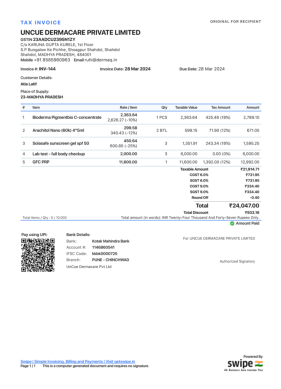

In [156]:
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import numpy as np

# Path to your PDF file
path = '/content/drive/MyDrive/Resumesameer/INV-144_Atia Latif.pdf'  # Update this path

# Convert PDF to images (you can specify which page you want)
images = convert_from_path(path)

# Show the first page (index 0)
img_1 = images[0]  # Change index to show different pages
img_1 = np.array(img_1)  # Convert PIL Image to NumPy array

# Display the image using Matplotlib
plt.imshow(img_1)
plt.axis('off')  # Hide axes
plt.show()


In [160]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pdf2image import convert_from_path
import os

def overlay_ocr_text(img_path, save_name):
    ''' loads an image, recognizes text, and overlays the text on the image. '''

    # Check if the input is a PDF
    if img_path.endswith('.pdf'):
        images = convert_from_path(img_path)
        img = np.array(images[0])  # Get the first page as a NumPy array
    else:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    dpi = 80
    fig_width, fig_height = int(img.shape[1] / dpi), int(img.shape[0] / dpi)  # Correct width and height for figsize
    plt.figure()
    f, axarr = plt.subplots(1, 2, figsize=(fig_width, fig_height))
    axarr[0].imshow(img)

    # Recognize text
    result = recognize_text(img_path)

    # Debugging: Print the structure of the result
    print("OCR Result Structure:", result)

    # If OCR prob is over 0.2, overlay bounding box and text
    for item in result:
        # Check if the item is a tuple and contains expected elements
        if isinstance(item, tuple):
            if len(item) >= 3:
                bbox, text, prob = item[0], item[1], item[2]
                if prob >= 0.2:
                    print(f'Detected text: {text} (Probability: {prob:.2f})')

                    # Get top-left and bottom-right bbox vertices
                    (top_left, top_right, bottom_right, bottom_left) = bbox
                    top_left = (int(top_left[0]), int(top_left[1]))
                    bottom_right = (int(bottom_right[0]), int(bottom_right[1]))

                    # Create a rectangle for bbox display
                    cv2.rectangle(img=img, pt1=top_left, pt2=bottom_right, color=(255, 0, 0), thickness=10)

                    # Put recognized text
                    cv2.putText(img=img, text=text, org=(top_left[0], top_left[1] - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 0, 0), thickness=8)
            else:
                print("Unexpected item format:", item)
        else:
            print("Item is not a tuple:", item)

    # Show and save image
    axarr[1].imshow(img)

    # Ensure the output directory exists
    os.makedirs('./Output', exist_ok=True)

    plt.savefig(f'./Output/{save_name}_overlay.jpg', bbox_inches='tight')
    plt.close()  # Close the plot to free memory

# Usage
path = '/content/drive/MyDrive/Resumesameer/INV-144_Atia Latif.pdf'  # Update this path
overlay_ocr_text(path, 'Text3_Output')


OCR Result Structure: [[([[66, 70], [144, 70], [144, 102], [66, 102]], 'TAX', 0.9996643455093459), ([[155, 69], [323, 69], [323, 105], [155, 105]], 'INVOICE', 0.9991481276345805), ([[1262, 65], [1585, 65], [1585, 92], [1262, 92]], 'ORIGINAL FOR RECIPIENT', 0.73779503582174), ([[63, 125], [827, 125], [827, 169], [63, 169]], 'UNCUE DERMACARE PRIVATE LIMITED', 0.9559290944173827), ([[64, 178], [416, 178], [416, 208], [64, 208]], 'GSTIN 23AADCU2395NIZY', 0.987809704697417), ([[64, 212], [530, 212], [530, 244], [64, 244]], 'Clo KARUNA GUPTA KURELE, Ist Floor', 0.5909830130006861), ([[63, 241], [699, 241], [699, 277], [63, 277]], 'S.P Bungalow Ke Pichhe, Shoagpur Shahdol, Shahdol', 0.8384075635472938), ([[63, 271], [519, 271], [519, 307], [63, 307]], 'Shahdol, MADHYA PRADESH, 484001', 0.693845614740067), ([[66, 306], [384, 306], [384, 338], [66, 338]], 'Mobile +91 8585960963', 0.6010696696345612), ([[399, 303], [681, 303], [681, 341], [399, 341]], 'Email ruhi@dermaq.in', 0.878273348195143), 

<Figure size 640x480 with 0 Axes>

In [163]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
import easyocr  # Make sure easyocr is installed

# Initialize the EasyOCR reader
reader = easyocr.Reader(['en'])  # Specify language(s) for OCR

def recognize_text(img_path):
    ''' Recognizes text in the image. '''
    if img_path.endswith('.pdf'):
        # Convert PDF to images
        images = convert_from_path(img_path)
        img_array = np.array(images[0])  # Get the first page
        result = reader.readtext(img_array)
    else:
        img = cv2.imread(img_path)
        result = reader.readtext(img)

    return result

def overlay_ocr_text(img_path, save_name):
    ''' Loads an image, recognizes text, and overlays the text on the image. '''

    # Load image or convert from PDF
    if img_path.endswith('.pdf'):
        images = convert_from_path(img_path)
        img = np.array(images[0])  # Convert first page of PDF to an image
    else:
        img = cv2.imread(img_path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display

    # Set up figure for displaying images
    dpi = 80
    fig_width, fig_height = img.shape[1] / dpi, img.shape[0] / dpi
    plt.figure(figsize=(fig_width, fig_height))

    # Recognize text
    result = recognize_text(img_path)

    # Create a copy for overlay
    overlay_img = img.copy()

    # Overlay text and bounding boxes
    for (bbox, text, prob) in result:
        if prob >= 0.2:  # Only consider results with probability >= 0.2
            print(f'Detected text: "{text}" (Probability: {prob:.2f})')

            # Get bounding box coordinates
            (top_left, top_right, bottom_right, bottom_left) = bbox
            top_left = (int(top_left[0]), int(top_left[1]))
            bottom_right = (int(bottom_right[0]), int(bottom_right[1]))

            # Create rectangle for bounding box
            cv2.rectangle(overlay_img, pt1=top_left, pt2=bottom_right, color=(255, 0, 0), thickness=5)

            # Put recognized text on the image
            cv2.putText(overlay_img, text, org=(top_left[0], top_left[1] - 10),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(255, 0, 0), thickness=2)

    # Display original and overlay images
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlay_img)
    plt.title('Overlay Image with OCR')
    plt.axis('off')

    # Save the overlay image
    output_path = f'./Output/{save_name}_overlay.jpg'
    plt.savefig(output_path, bbox_inches='tight')
    plt.close()  # Close the plot to free memory

    print(f'Overlay image saved at: {output_path}')

# Usage
path = '/content/drive/MyDrive/Resumesameer/INV-144_Atia Latif.pdf'  # Update this path to your PDF
overlay_ocr_text(path, 'Text3_Output')


Detected text: "TAX" (Probability: 1.00)
Detected text: "INVOICE" (Probability: 1.00)
Detected text: "ORIGINAL FOR RECIPIENT" (Probability: 0.74)
Detected text: "UNCUE DERMACARE PRIVATE LIMITED" (Probability: 0.96)
Detected text: "GSTIN 23AADCU2395NIZY" (Probability: 0.99)
Detected text: "Clo KARUNA GUPTA KURELE, Ist Floor" (Probability: 0.59)
Detected text: "S.P Bungalow Ke Pichhe, Shoagpur Shahdol, Shahdol" (Probability: 0.84)
Detected text: "Shahdol, MADHYA PRADESH, 484001" (Probability: 0.69)
Detected text: "Mobile +91 8585960963" (Probability: 0.60)
Detected text: "Email ruhi@dermaq.in" (Probability: 0.88)
Detected text: "Invoice #: INV-144" (Probability: 0.94)
Detected text: "Invoice Date: 28 Mar 2024" (Probability: 0.94)
Detected text: "Due Date: 28 Mar 2024" (Probability: 0.83)
Detected text: "Customer Details:" (Probability: 0.68)
Detected text: "Atia Latif" (Probability: 1.00)
Detected text: "Place of Supply:" (Probability: 0.98)
Detected text: "23-MADHYA PRADESH" (Probabilit